# Titanic

https://www.kaggle.com/code/yassineghouzam/titanic-top-4-with-ensemble-modeling/notebook

## 1. Import libraries and load datasets

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.family'] = 'Avenir'

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

## 2. Load and check Data

### 2.1 Load data

In [15]:
# Load data
#### Load train and Test datasets

train = pd.read_csv('~/aiffel/data/titanic_train.csv')
test = pd.read_csv('~/aiffel/data/titanic_test.csv')
IDtest = test['PassengerId']

In [16]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [17]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### 2.2 Outlier detection

In [18]:
# Outlier detection

def detect_outliers(df, n, features):
    '''
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    '''
    outlier_indices = []

    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col], 75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1

        # Outlier step
        outlier_step = 1.5 * IQR

        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index

        # Append the found outlier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)

    # Select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n)

    return multiple_outliers

# Detect outliers from Age, SibSp, Parch and Fare
Outliers_to_drop = detect_outliers(train, 2, ['Age', 'SibSp', 'Parch', 'Fare'])

In [19]:
# show the outliers
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


PassenderId 28, 89, and 342 have high Fare amount.

The others have high SibSp number.

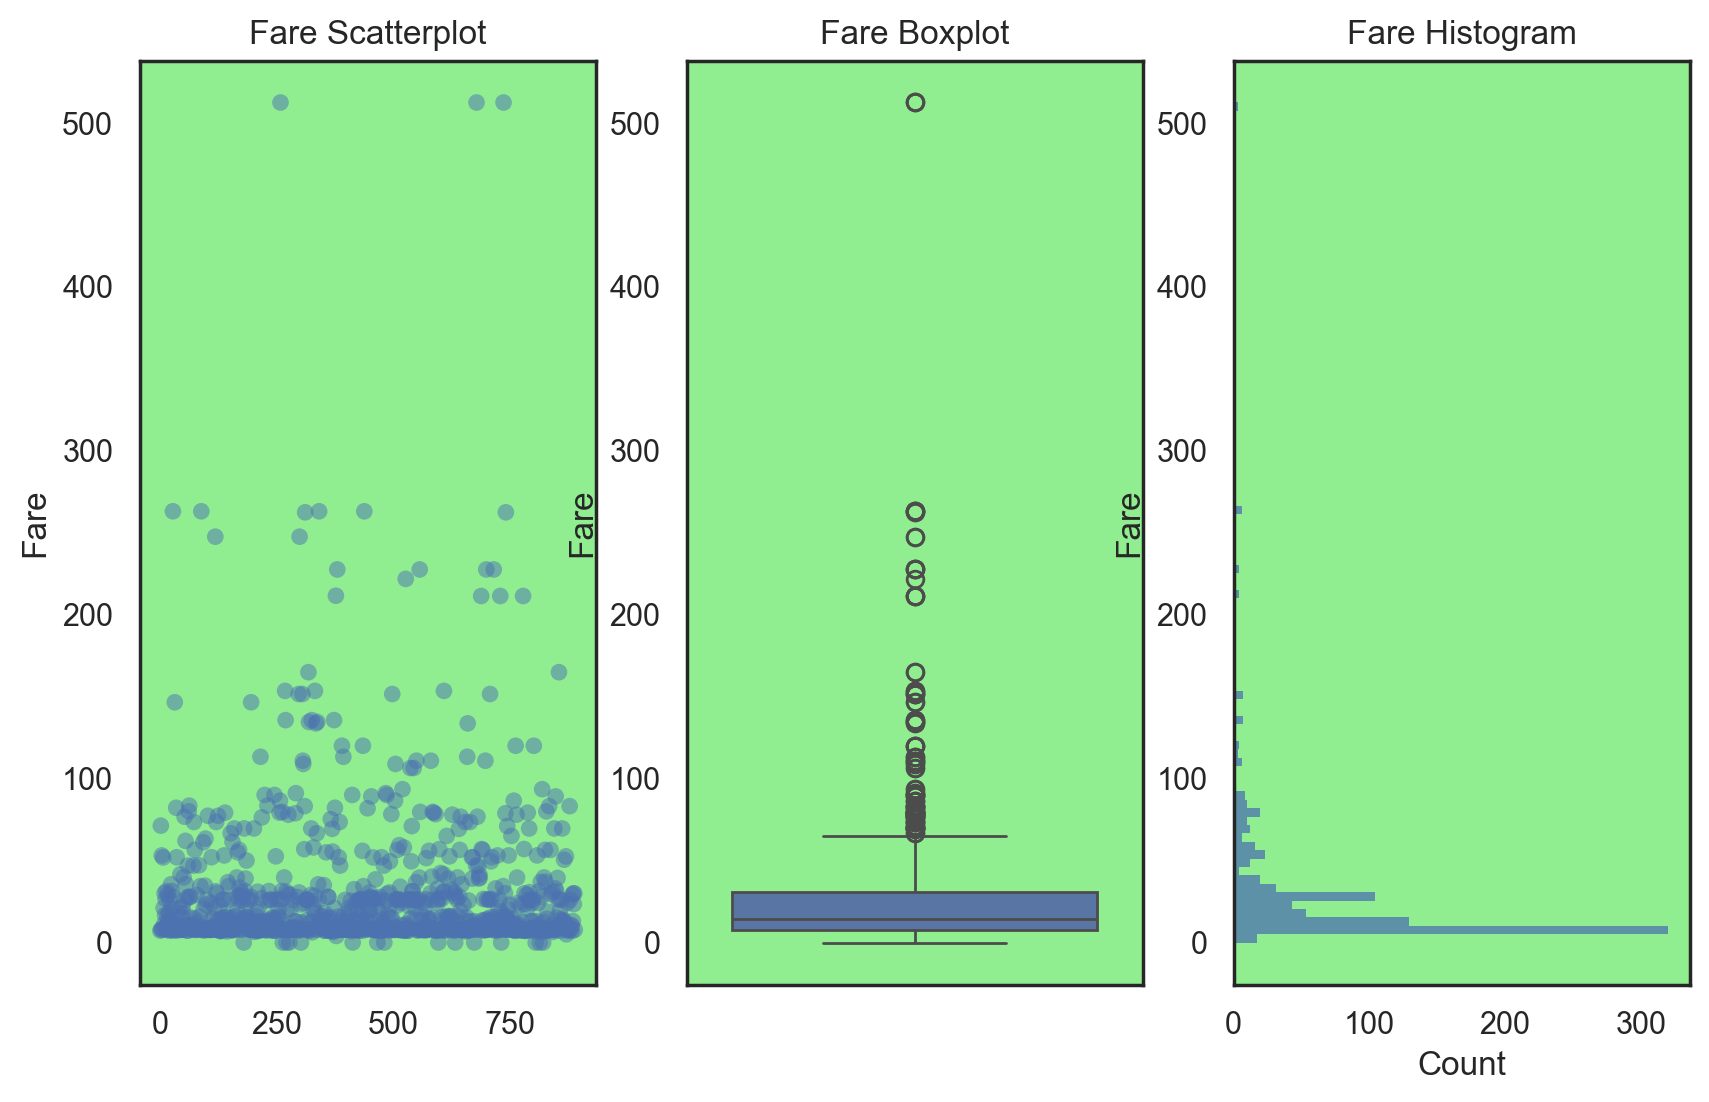

In [20]:
f, ax = plt.subplots(1, 3, figsize = (10, 6))

sns.scatterplot(x = train.index, y = 'Fare', data = train, ax = ax[0], alpha = 0.5, edgecolor = 'none')
ax[0].set_title('Fare Scatterplot')
ax[0].set_xlabel('')
ax[0].set_facecolor('lightgreen')

sns.boxplot(y = 'Fare', data = train, ax = ax[1])
ax[1].set_title('Fare Boxplot')
ax[1].set_facecolor('lightgreen')


sns.histplot(y = 'Fare', data = train, bins = 100, edgecolor = 'none', ax = ax[2])
ax[2].set_title('Fare Histogram')
ax[2].set_facecolor('lightgreen')

In [21]:
train['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [22]:
Q1 = np.percentile(train['Fare'], 25)
Q3 = np.percentile(train['Fare'], 75)
IQR = Q3 - Q1
outlier_step = 1.5 * IQR
outlier_low = Q1 - outlier_step
outlier_high = Q3 + outlier_step

print('Q1:', Q1)
print('Q3:', Q3)
print('IQR:', IQR)
print('outlier_step:', outlier_step)
print('outlier_low:', outlier_low)
print('outlier_high:', outlier_high)

Q1: 7.9104
Q3: 31.0
IQR: 23.0896
outlier_step: 34.6344
outlier_low: -26.724
outlier_high: 65.6344


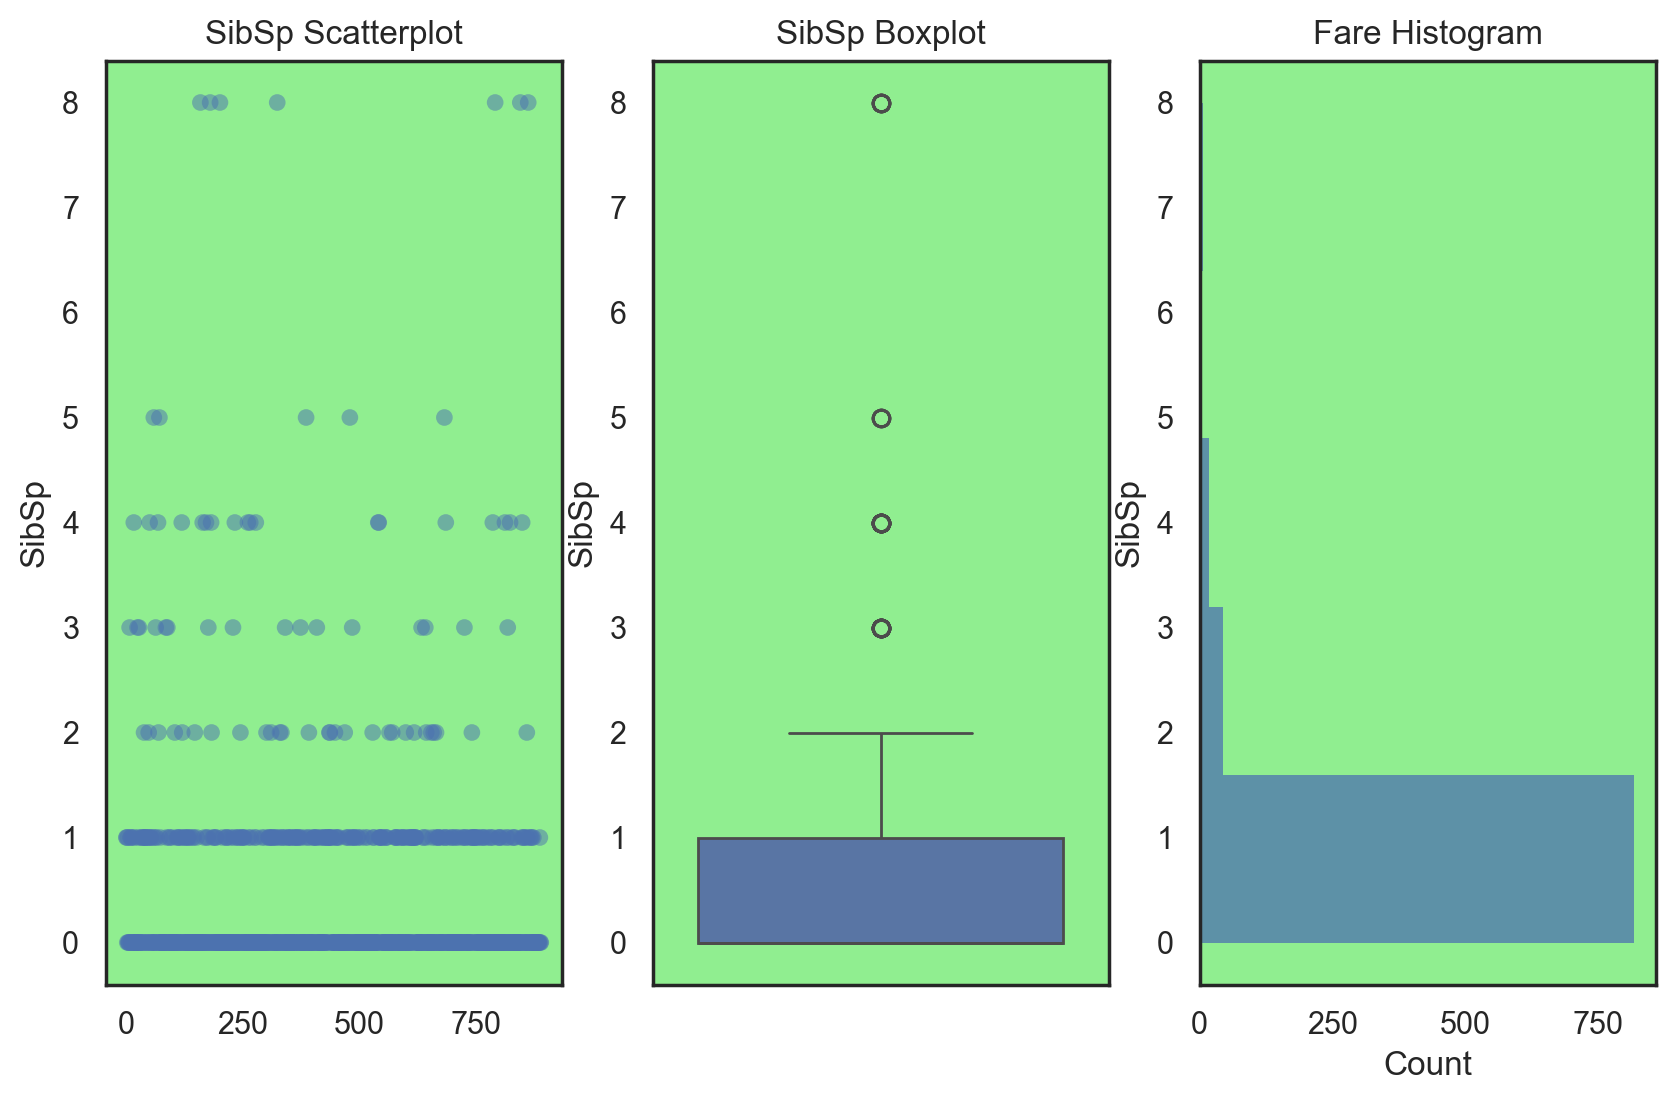

In [23]:
f, ax = plt.subplots(1, 3, figsize = (10, 6))

sns.scatterplot(x = train.index, y = 'SibSp', data = train, ax = ax[0], alpha = 0.5, edgecolor = 'none')
ax[0].set_title('SibSp Scatterplot')
ax[0].set_xlabel('')
ax[0].set_facecolor('lightgreen')

sns.boxplot(y = 'SibSp', data = train, ax = ax[1])
ax[1].set_title('SibSp Boxplot')
ax[1].set_facecolor('lightgreen')


sns.histplot(y = 'SibSp', data = train, bins = 5, edgecolor = 'none', ax = ax[2])
ax[2].set_title('Fare Histogram')
ax[2].set_facecolor('lightgreen')

In [24]:
train['SibSp'].describe()

count    891.000000
mean       0.523008
std        1.102743
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        8.000000
Name: SibSp, dtype: float64

In [25]:
Q1 = np.percentile(train['SibSp'], 25)
Q3 = np.percentile(train['SibSp'], 75)
IQR = Q3 - Q1
outlier_step = 1.5 * IQR
outlier_low = Q1 - outlier_step
outlier_high = Q3 + outlier_step

print('Q1:', Q1)
print('Q3:', Q3)
print('IQR:', IQR)
print('outlier_step:', outlier_step)
print('outlier_low:', outlier_low)
print('outlier_high:', outlier_high)

Q1: 0.0
Q3: 1.0
IQR: 1.0
outlier_step: 1.5
outlier_low: -1.5
outlier_high: 2.5


In [26]:
# Drop outliers
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop = True)

### 2.3 Joining train and test set